# Профильное задание ML-инженер

**Задача: классификация спам-сообщений**

**Submissions are evaluated on AUC_ROC**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import textstat
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, word_tokenize
from nltk.corpus import stopwords,  wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re

import torch
from torch import nn, optim
import torch.nn.functional as F
import pytorch_lightning as L
import torchmetrics

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

NUM_THREADS = 12
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import os
from typing import Callable

# logging
import wandb
wandb.login()

# Visual settings
pd.set_option('display.max_rows', 500)
from IPython.display import display
from tabulate import tabulate
SEED = 42

import warnings
warnings.filterwarnings('ignore')

from catboost import CatBoostClassifier
import fasttext
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
def make_oof_prediction(models, X_test, n_classes=2):
    preds = np.zeros((len(X_test), n_classes))
    for md in models:
        preds += md.predict_proba(X_test)
    preds = preds[:, 1] / len(models)
    return preds


def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

## Global data preparation

In [ ]:
root = '../data/'
sub_root = '../submissions/'
seed_everything(SEED)

full_train = pd.read_csv(root + 'train_spam.csv')
test = pd.read_csv(root + 'test_spam.csv')

print(full_train.columns)

full_train.head()

Index(['text_type', 'text'], dtype='object')


,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


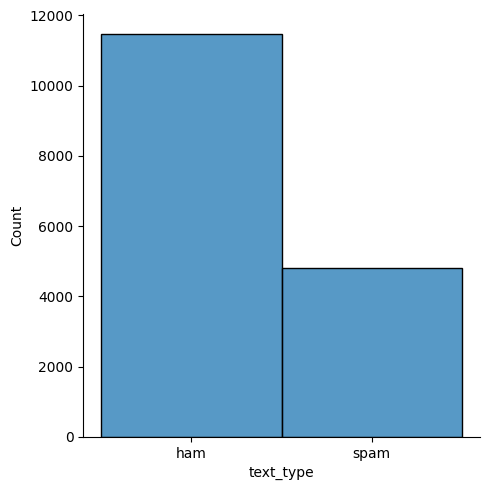

In [ ]:
sns.displot(full_train.text_type);

## Text preprocessing

In [ ]:
full_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [ ]:
tok = TweetTokenizer()
en_sw = [] # stopwords.words('english')

full_train['text'] = full_train['text'].progress_apply(lambda txt: ' '.join([token.lower() for token in tok.tokenize(txt) if token.lower()  not in en_sw]))
test['text'] = test['text'].progress_apply(lambda txt: ' '.join([token.lower()  for token in tok.tokenize(txt) if token.lower()  not in en_sw]))


  0%|          | 0/16278 [00:00<?, ?it/s]

  0%|          | 0/4070 [00:00<?, ?it/s]

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language='english')

full_train['text'] = full_train['text'].progress_apply(lambda el: ' '.join([stemmer.stem(word) for word in el.split()]))
test['text'] = test['text'].progress_apply(lambda el: ' '.join([stemmer.stem(word) for word in el.split()]))


  0%|          | 0/16278 [00:00<?, ?it/s]

  0%|          | 0/4070 [00:00<?, ?it/s]

In [ ]:
full_train

,text_type,text
0,ham,make sure alex know his birthday is over in fi...
1,ham,a resum for john lavorato thank vinc i will ge...
2,spam,plzz visit my websit moviesgodml to get all mo...
3,spam,urgent your mobil number has been award with a...
4,ham,overview of hr associ analyst project per davi...
...,...,...
16273,spam,if you are interest in binari option trade so ...
16274,spam,dirti pictureblyk on aircel thank you for be a...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reel par 80 गंद bhara pada hai 👀 kuch bh...


In [ ]:
display(full_train.head(1))

seed_everything(SEED)

X = full_train[['text']]
y = full_train['text_type']

params = {
    'depth': 6,
    'learning_rate': 0.03,
    'iterations': 10000,
    'eval_metric': 'AUC',
    'verbose': 500,
    'random_seed': SEED,
}

n_splits = 5

models = []
metrics = []

kf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

# цикл по фолдам
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'FOLD --> {i}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    veccer = TfidfVectorizer(max_features=1000)
    X_train = veccer.fit_transform(X_train['text']).toarray()
    X_test = veccer.transform(X_test['text']).toarray()

    model = LogisticRegression(random_state=SEED, n_jobs=12)
    model.fit(X_train, y_train)
    models.append(model)

    y_pred = model.predict_proba(X_test)[:, 1]

    metric = roc_auc_score(y_test, y_pred)
    metrics.append(metric)
    print(f"ROC_AUC for fold {i}: {metric}\n\n")


print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))


,text_type,text
0,ham,make sure alex knows his birthday is over in f...


FOLD --> 0
ROC_AUC for fold 0: 0.9616417872620827


FOLD --> 1
ROC_AUC for fold 1: 0.9633630525565748


FOLD --> 2
ROC_AUC for fold 2: 0.9607486165055293


FOLD --> 3
ROC_AUC for fold 3: 0.956725537026113


FOLD --> 4
ROC_AUC for fold 4: 0.9620786092214664


ROC_AUC: [0.9616417872620827, 0.9633630525565748, 0.9607486165055293, 0.956725537026113, 0.9620786092214664]
MEAN - STD: 0.958655223086838


# CatBoost training

In [ ]:
display(full_train.head(1))

seed_everything(SEED)

X = full_train[['text']]
y = full_train['text_type']

params = {
    'depth': 6,
    'learning_rate': 0.03,
    'iterations': 10000,
    'eval_metric': 'AUC',
    'verbose': 500,
    'random_seed': SEED,
}

n_splits = 5

models = []
metrics = []

kf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

# цикл по фолдам
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'FOLD --> {i}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    veccer = TfidfVectorizer(max_features=1000)
    X_train = veccer.fit_transform(X_train['text']).toarray()
    X_test = veccer.transform(X_test['text']).toarray()

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=1000)
    models.append(model)

    y_pred = model.predict_proba(X_test)[:, 1]

    metric = roc_auc_score(y_test, y_pred)
    metrics.append(metric)
    print(f"ROC_AUC for fold {i}: {metric}\n\n")


print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))


,text_type,text
0,ham,make sure alex knows his birthday is over in f...


FOLD --> 0
0:	test: 0.7487487	best: 0.7487487 (0)	total: 43.6ms	remaining: 7m 15s
500:	test: 0.9641401	best: 0.9641496 (499)	total: 21.9s	remaining: 6m 55s
1000:	test: 0.9704032	best: 0.9704032 (1000)	total: 44.1s	remaining: 6m 36s
1500:	test: 0.9731292	best: 0.9731555 (1476)	total: 1m 4s	remaining: 6m 7s
2000:	test: 0.9745856	best: 0.9745896 (1995)	total: 1m 25s	remaining: 5m 41s
2500:	test: 0.9754902	best: 0.9755084 (2480)	total: 1m 46s	remaining: 5m 18s
3000:	test: 0.9759158	best: 0.9759675 (2962)	total: 2m 7s	remaining: 4m 57s
3500:	test: 0.9758885	best: 0.9760178 (3157)	total: 2m 29s	remaining: 4m 38s
4000:	test: 0.9761726	best: 0.9762265 (3977)	total: 2m 51s	remaining: 4m 17s
4500:	test: 0.9761158	best: 0.9762710 (4147)	total: 3m 13s	remaining: 3m 56s
5000:	test: 0.9760800	best: 0.9762710 (4147)	total: 3m 36s	remaining: 3m 36s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9762710057
bestIteration = 4147

Shrink model to first 4148 iterations.
ROC_AUC for f

## text_features Catboost training

In [ ]:
display(full_train.head(1))

seed_everything(SEED)

X = full_train[['text']]
y = full_train['text_type']

params = {
    'depth': 6,
    'learning_rate': 0.03,
    'iterations': 10000,
    'eval_metric': 'AUC',
    'verbose': 500,
    'random_seed': SEED,
    'text_features': ['text']
}

n_splits = 5

models = []
metrics = []

kf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'FOLD --> {i}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=1000)
    models.append(model)

    y_pred = model.predict_proba(X_test)[:, 1]

    metric = roc_auc_score(y_test, y_pred)
    metrics.append(metric)
    print(f"ROC_AUC for fold {i}: {metric}\n\n")


print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))


,text_type,text
0,ham,make sure alex knows his birthday is over in f...


FOLD --> 0
0:	test: 0.9347275	best: 0.9347275 (0)	total: 44.9ms	remaining: 7m 28s
500:	test: 0.9862138	best: 0.9862297 (472)	total: 27s	remaining: 8m 32s
1000:	test: 0.9876760	best: 0.9876760 (1000)	total: 53.9s	remaining: 8m 4s
1500:	test: 0.9879546	best: 0.9879800 (1396)	total: 1m 21s	remaining: 7m 44s
2000:	test: 0.9881331	best: 0.9881526 (1977)	total: 1m 50s	remaining: 7m 20s
2500:	test: 0.9881594	best: 0.9881907 (2450)	total: 2m 19s	remaining: 6m 58s
3000:	test: 0.9881935	best: 0.9881935 (2689)	total: 2m 46s	remaining: 6m 28s
3500:	test: 0.9882443	best: 0.9882620 (3326)	total: 3m 13s	remaining: 5m 59s
4000:	test: 0.9882937	best: 0.9883096 (3945)	total: 3m 41s	remaining: 5m 31s
4500:	test: 0.9884566	best: 0.9884670 (4474)	total: 4m 9s	remaining: 5m 4s
5000:	test: 0.9885986	best: 0.9886072 (4987)	total: 4m 37s	remaining: 4m 37s
5500:	test: 0.9886825	best: 0.9886862 (5499)	total: 5m 5s	remaining: 4m 9s
6000:	test: 0.9887311	best: 0.9887370 (5973)	total: 5m 32s	remaining: 3m 41s
6500:

In [ ]:
submission = pd.DataFrame()
submission['ID'] = test.index
submission['label'] = classes

submission.to_csv(sub_root + 'catboost_text_features_oof_balanced_clean.csv', index=False)
submission

,ID,label
0,0,neutral
1,1,neutral
2,2,negative
3,3,positive
4,4,negative
...,...,...
2519,2519,positive
2520,2520,negative
2521,2521,positive
2522,2522,positive


---

In [ ]:
meth_ignore_list = ['set_lang',  # Not appropriate
                    # 'dale_chall_readability_score', # Fails inference
                    # 'dale_chall_readability_score_v2', # Fails inference
                    # 'difficult_words', # Fails inference
                    # 'gunning_fog', # Fails inference
                    'fernandez_huerta', 'szigriszt_pazos', 'gutierrez_polini', 'crawford', 'osman', 'gulpease_index', 'wiener_sachtextformel']
good_methods: dict[str, Callable] = {}

for meth_name in dir(textstat):
    # print(meth_name)
    if not meth_name.startswith('__') and meth_name not in meth_ignore_list:
        meth = getattr(textstat, meth_name)
        if isinstance(meth, Callable):
            try:
                res = meth(full_train.text.iloc[0])
                if isinstance(res, (int, float, bool)):
                    print(meth_name, res)
                    good_methods[meth_name] = meth
            except Exception as e:
                print(e)
                raise e

automated_readability_index 5.7
avg_character_per_word 4.06
avg_letter_per_word 4.06
avg_sentence_length 16.0
avg_sentence_per_word 0.06
avg_syllables_per_word 1.3
char_count 65
coleman_liau_index 5.97
count_arabic_long_words 3
count_arabic_syllables 63
count_complex_arabic_words 0
count_faseeh 0
dale_chall_readability_score 7.39
dale_chall_readability_score_v2 6.4
difficult_words 2
flesch_kincaid_grade 6.0
flesch_reading_ease 80.62
gunning_fog 6.4
is_difficult_word True
is_easy_word False
letter_count 65
lexicon_count 16
linsear_write_formula 7.0
lix 34.75
long_word_count 3
mcalpine_eflaw 22.0
miniword_count 6
monosyllabcount 12
polysyllabcount 0
reading_time 0.95
rix 3.0
sentence_count 1
smog_index 0.0
spache_readability 4.17
syllable_count 20
words_per_sentence 16.0


In [ ]:
def apply_textstat(text, meth):
    try:
        res = meth(text)
    except OSError:
        return None
    return res

In [ ]:
for meth_name, meth in tqdm(good_methods.items()):
    full_train[meth_name] = full_train['text'].apply(apply_textstat, args=(meth,))
for meth_name, meth in tqdm(good_methods.items()):
    test[meth_name] = test['text'].apply(apply_textstat, args=(meth,))


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
full_train

,text_type,text,automated_readability_index,avg_character_per_word,avg_letter_per_word,avg_sentence_length,avg_sentence_per_word,avg_syllables_per_word,char_count,coleman_liau_index,...,miniword_count,monosyllabcount,polysyllabcount,reading_time,rix,sentence_count,smog_index,spache_readability,syllable_count,words_per_sentence
0,ham,make sure alex know his birthday is over in fi...,5.7,4.06,4.06,16.0,0.06,1.3,65,5.97,...,6,12,0,0.95,3.0,1,0.0,4.17,20,16.0
1,ham,a resum for john lavorato thank vinc i will ge...,45.8,3.98,3.98,97.0,0.01,1.4,386,6.99,...,41,76,10,5.67,12.0,1,0.0,15.58,131,97.0
2,spam,plzz visit my websit moviesgodml to get all mo...,10.5,4.45,4.27,22.0,0.05,1.4,98,7.49,...,10,15,1,1.44,3.0,1,0.0,5.50,30,22.0
3,spam,urgent your mobil number has been award with a...,13.0,4.87,4.83,23.0,0.04,1.2,112,11.03,...,2,18,0,1.65,2.0,1,0.0,5.58,28,23.0
4,ham,overview of hr associ analyst project per davi...,62.9,4.43,4.43,127.0,0.01,1.4,563,9.60,...,46,76,5,8.27,21.0,1,0.0,20.64,183,127.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16273,spam,if you are interest in binari option trade so ...,9.1,4.47,4.42,19.0,0.05,1.4,85,8.36,...,9,13,2,1.25,4.0,1,0.0,5.78,27,19.0
16274,spam,dirti pictureblyk on aircel thank you for be a...,36.7,4.60,4.59,73.0,0.01,1.4,336,10.53,...,26,49,2,4.94,9.0,1,0.0,13.37,99,73.0
16275,ham,or you could do this g on mon 1635465 sep 1635...,74.6,4.04,4.04,154.0,0.01,1.2,622,7.34,...,68,130,6,9.14,25.0,1,0.0,23.56,187,154.0
16276,ham,insta reel par 80 गंद bhara pada hai 👀 kuch bh...,6.4,3.89,3.74,19.0,0.05,1.2,74,4.41,...,9,16,1,1.09,0.0,1,0.0,4.88,23,19.0


34 features


IndexError: index 38 is out of bounds for axis 0 with size 38

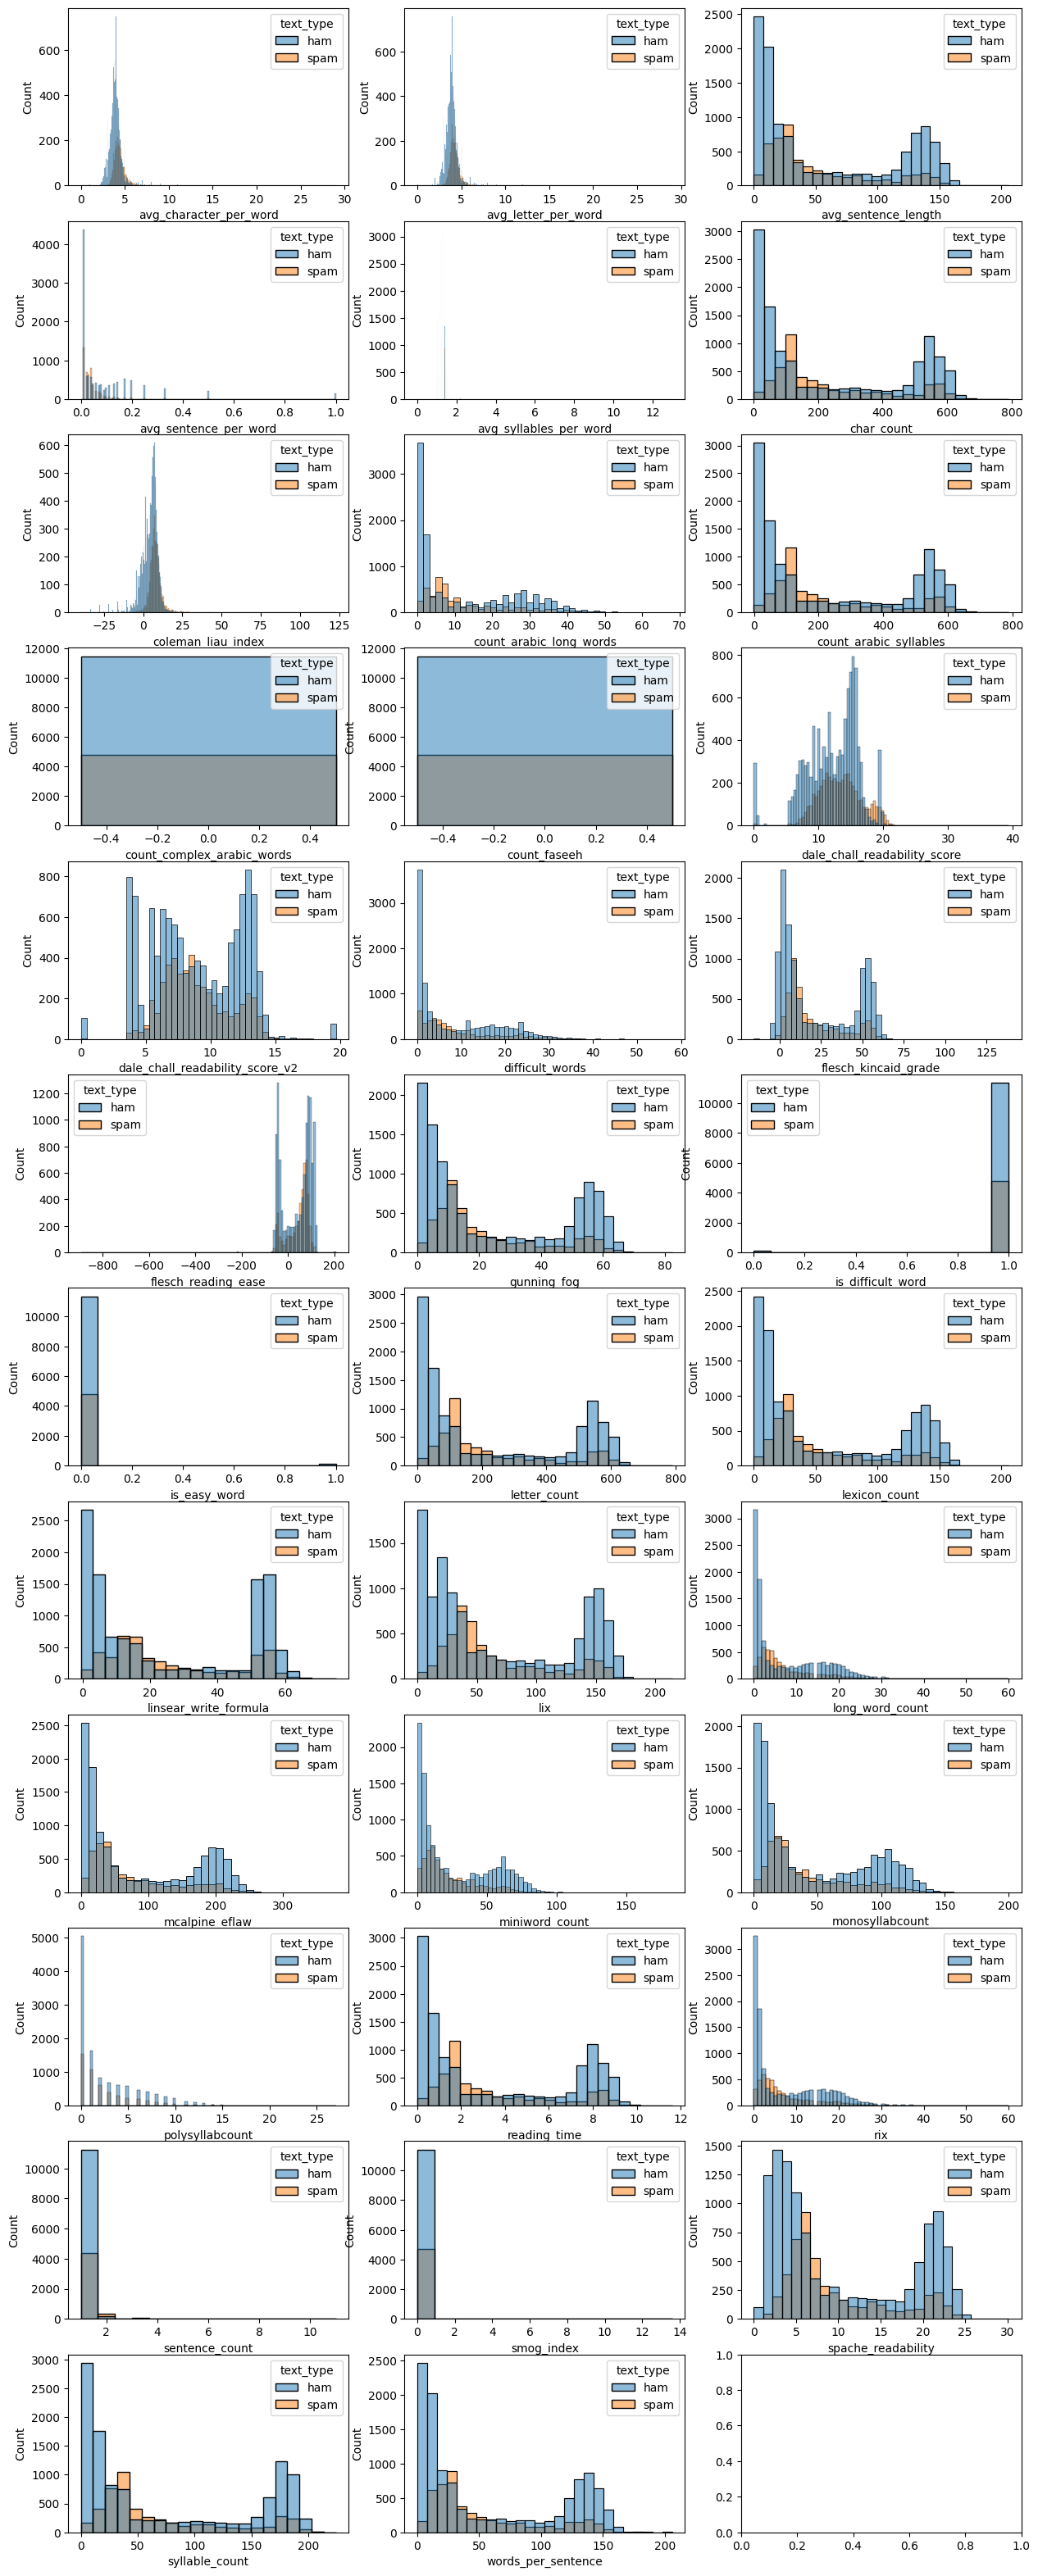

In [ ]:
fig, axes = plt.subplots(12, 3, figsize=(15, 40))

print(len(full_train.columns[3:-1]), 'features')

for i in range(0, len(full_train.columns[3:-1]), 3):
    sns.histplot(
        full_train,
        x=full_train.columns[3+i],
        hue='text_type',
        ax=axes[i // 3][0],

    )
    # axes[i // 2][0].set_title(_X_train.columns[3+i])

    sns.histplot(
        full_train,
        x=full_train.columns[3+i+1],
        hue='text_type',
        ax=axes[i // 3][1]
    )


    sns.histplot(
        full_train,
        x=full_train.columns[3+i+2],
        hue='text_type',
        ax=axes[i // 3][2]
    )
plt.tight_layout()

In [ ]:
# С использованием стемминга

display(full_train.head(1))

seed_everything(SEED)

X = full_train[full_train.columns[1:]]
y = full_train['text_type']

params = {
    'depth': 6,
    'learning_rate': 0.03,
    'iterations': 10000,
    'eval_metric': 'AUC',
    'verbose': 500,
    'random_seed': SEED,
    'text_features': ['text']
}

n_splits = 5

models = []
metrics = []

kf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'FOLD --> {i}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=500)
    models.append(model)

    y_pred = model.predict_proba(X_test)[:, 1]

    metric = roc_auc_score(y_test, y_pred)
    metrics.append(metric)
    print(f"ROC_AUC for fold {i}: {metric}\n\n")


print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))


,text_type,text,automated_readability_index,avg_character_per_word,avg_letter_per_word,avg_sentence_length,avg_sentence_per_word,avg_syllables_per_word,char_count,coleman_liau_index,...,miniword_count,monosyllabcount,polysyllabcount,reading_time,rix,sentence_count,smog_index,spache_readability,syllable_count,words_per_sentence
0,ham,make sure alex know his birthday is over in fi...,5.7,4.06,4.06,16.0,0.06,1.3,65,5.97,...,6,12,0,0.95,3.0,1,0.0,4.17,20,16.0


FOLD --> 0
0:	test: 0.9349326	best: 0.9349326 (0)	total: 42ms	remaining: 6m 59s
500:	test: 0.9897214	best: 0.9897278 (496)	total: 27.4s	remaining: 8m 39s
1000:	test: 0.9908208	best: 0.9908291 (990)	total: 55.1s	remaining: 8m 15s
1500:	test: 0.9912853	best: 0.9912867 (1497)	total: 1m 22s	remaining: 7m 48s
2000:	test: 0.9915314	best: 0.9915374 (1998)	total: 1m 50s	remaining: 7m 21s
2500:	test: 0.9917213	best: 0.9917226 (2499)	total: 2m 17s	remaining: 6m 51s
3000:	test: 0.9919240	best: 0.9919318 (2990)	total: 2m 44s	remaining: 6m 24s
3500:	test: 0.9920880	best: 0.9920940 (3490)	total: 3m 12s	remaining: 5m 57s
4000:	test: 0.9922318	best: 0.9922318 (4000)	total: 3m 40s	remaining: 5m 30s
4500:	test: 0.9922862	best: 0.9922885 (4497)	total: 4m 8s	remaining: 5m 3s
5000:	test: 0.9923489	best: 0.9923489 (5000)	total: 4m 35s	remaining: 4m 34s
5500:	test: 0.9923719	best: 0.9923774 (5448)	total: 5m 3s	remaining: 4m 8s
6000:	test: 0.9923839	best: 0.9923862 (5597)	total: 5m 30s	remaining: 3m 40s
6500:

In [ ]:
display(full_train.head(1))

seed_everything(SEED)

X = full_train[full_train.columns[1:]]
y = full_train['text_type']

params = {
    'depth': 6,
    'learning_rate': 0.03,
    'iterations': 10000,
    'eval_metric': 'AUC',
    'verbose': 500,
    'random_seed': SEED,
    'text_features': ['text']
}

n_splits = 5

models = []
metrics = []

kf = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'FOLD --> {i}')
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=1000)
    models.append(model)

    y_pred = model.predict_proba(X_test)[:, 1]

    metric = roc_auc_score(y_test, y_pred)
    metrics.append(metric)
    print(f"ROC_AUC for fold {i}: {metric}\n\n")


print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))


,text_type,text,automated_readability_index,avg_character_per_word,avg_letter_per_word,avg_sentence_length,avg_sentence_per_word,avg_syllables_per_word,char_count,coleman_liau_index,...,miniword_count,monosyllabcount,polysyllabcount,reading_time,rix,sentence_count,smog_index,spache_readability,syllable_count,words_per_sentence
0,ham,make sure alex knows his birthday is over in f...,7.5,4.44,4.44,16.0,0.06,1.3,71,8.18,...,6,12,0,1.04,4.0,1,0.0,4.17,20,16.0


FOLD --> 0
0:	test: 0.9426653	best: 0.9426653 (0)	total: 28.4ms	remaining: 4m 43s
500:	test: 0.9892398	best: 0.9892472 (499)	total: 27.6s	remaining: 8m 43s
1000:	test: 0.9902624	best: 0.9902647 (999)	total: 55.8s	remaining: 8m 21s
1500:	test: 0.9909273	best: 0.9909310 (1482)	total: 1m 23s	remaining: 7m 52s
2000:	test: 0.9913554	best: 0.9913646 (1994)	total: 1m 50s	remaining: 7m 23s
2500:	test: 0.9915913	best: 0.9915941 (2490)	total: 2m 19s	remaining: 6m 58s
3000:	test: 0.9917369	best: 0.9917498 (2990)	total: 2m 47s	remaining: 6m 29s
3500:	test: 0.9918494	best: 0.9918507 (3499)	total: 3m 14s	remaining: 6m
4000:	test: 0.9918941	best: 0.9919139 (3845)	total: 3m 41s	remaining: 5m 32s
4500:	test: 0.9919738	best: 0.9919742 (4494)	total: 4m 8s	remaining: 5m 4s
5000:	test: 0.9919669	best: 0.9919844 (4882)	total: 4m 37s	remaining: 4m 36s
5500:	test: 0.9920175	best: 0.9920199 (5479)	total: 5m 4s	remaining: 4m 9s
6000:	test: 0.9920673	best: 0.9920751 (5901)	total: 5m 31s	remaining: 3m 40s
6500:	t

# FastText

In [ ]:
seed_everything(SEED)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

X = full_train[full_train.columns[1:]]
y = full_train['text_type']

metrics, models = [], []

for i, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_tr, y_tr = X.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]

    with open('train.txt', 'wt', encoding='UTF-8') as f:
        for k in range(X_tr.shape[0]):
            f.write(f"__label__{y_tr.iloc[k]} {X_tr.iloc[k]['text']}\n")
    with open('eval.txt', 'wt', encoding='UTF-8') as f:
        for k in range(X_val.shape[0]):
            f.write(f"__label__{y_val.iloc[k]} {X_val.iloc[k]['text']}\n")

    model = fasttext.train_supervised(input="train.txt")

    y_pred = []
    for k in range(X_val.shape[0]):
        # print(X_val.iloc[k]['Tweet'].strip())
        full_pred = model.predict(X_val.iloc[k]['text'].replace('\n', ' '))
        # print(full_pred)
        if 'ham' in full_pred[0]:
            y_pred.append(torch.tensor(full_pred[1][0]).sigmoid())
        else:
            y_pred.append(1 - torch.tensor(full_pred[1][0]).sigmoid())

    score = roc_auc_score(y_val, torch.tensor(y_pred))
    metrics.append(score)
    print(f"ROC_AUC for fold {i}: {score}")

    models.append(model)

print('ROC_AUC:', metrics)
print('MEAN - STD:', np.mean(metrics) - np.std(metrics))

ROC_AUC for fold 0: 0.6930492803443103
ROC_AUC for fold 1: 0.6998119436101415
ROC_AUC for fold 2: 0.685297648291141
ROC_AUC for fold 3: 0.6979699179985761
ROC_AUC for fold 4: 0.6964635012254059
ROC_AUC: [0.6930492803443103, 0.6998119436101415, 0.685297648291141, 0.6979699179985761, 0.6964635012254059]
MEAN - STD: 0.6894018466446648


In [ ]:
np.mean([0.6930492803443103, 0.6998119436101415, 0.685297648291141, 0.6979699179985761, 0.6964635012254059])

0.6945184582939149

# CNN

In [ ]:
PAD = '<pad>'
UNK = '<unk>'

def preprocess_data(data: pd.Series, tokenizer: Callable = TweetTokenizer().tokenize, pad_token=PAD, unk_token=UNK):
    #all unique characters go here    (letters)
    tokens = [pad_token, unk_token] + list(set(tokenizer(data.str.cat(sep=' '))))

    num_tokens = len(tokens)
    print ('num_tokens = ', num_tokens)
    print('Tokens example:', tokens[:5])

    token_to_id = {token: idx for idx, token in enumerate(tokens)}
    print('num_encoded_tokens =', len(token_to_id))
    print('Tokens encoding example:', list(token_to_id.items())[:5])

    # Создадим словарь <символ> -> <id>
    assert len(tokens) == len(token_to_id), "dictionaries must have same size"

    for i in range(num_tokens):
        assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

    print("Seems alright!")

    return tokens, token_to_id

tokens, token_to_id = preprocess_data(full_train['text'])

num_tokens =  54490
Tokens example: ['<pad>', '<unk>', 'faades', 'farker', '1095']
num_encoded_tokens = 54490
Tokens encoding example: [('<pad>', 0), ('<unk>', 1), ('faades', 2), ('farker', 3), ('1095', 4)]
Seems alright!


In [ ]:
tokens[:10]

['<pad>',
 '<unk>',
 'faades',
 'farker',
 '1095',
 'reduce',
 'smiley',
 'buildin',
 '24cash',
 'ho']

In [ ]:
test['text']

0       j jim whitehead ejw cse ucsc edu writes j you ...
1       original message from bitbitch magnesium net p...
2       java for managers vince durasoft who just taug...
3                    there is a youtuber name saiman says
4       underpriced issue with high return on equity t...
                              ...                        
4065    husband to wifetum meri zindagi hoorwifeor kya...
4066    baylor enron case study cindy yes i shall co a...
4067                             boring as compared to tp
4068    hellogorgeous hows u my fone was on charge lst...
4069    energy conference mark we are really swamped a...
Name: text, Length: 4070, dtype: object

In [ ]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True, tokenizer=TweetTokenizer().tokenize):
    """Casts a list of names into rnn-digestable matrix"""
    # print(data)
    data = data.apply(tokenizer).tolist()

    # print(data[:1])

    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[PAD]

    for i in range(len(data)):
        line_ix = [token_to_id[c] if c in token_to_id else token_to_id[UNK] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

display(full_train['text'].head(1).iloc[0])
print()

X_train_matr = torch.tensor(to_matrix(full_train['text'], token_to_id), dtype=torch.int64)

mapper = {
    'ham': 0,
    'spam': 1
}

y = full_train['text_type'].apply(lambda el: mapper[el])


X_train_matr, X_eval_matr, y_train, y_eval = train_test_split(X_train_matr, y, test_size=0.2, random_state=SEED)
max_len = X_train_matr.shape[1]

'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned'

In [ ]:
X_train_matr

tensor([[19764, 27363, 46840,  ...,     0,     0,     0],
        [ 8856, 14717, 12917,  ...,     0,     0,     0],
        [51303, 52695, 12917,  ...,     0,     0,     0],
        ...,
        [18200, 17466, 40236,  ...,     0,     0,     0],
        [24496, 24496, 21963,  ...,     0,     0,     0],
        [42720,   355, 23688,  ...,     0,     0,     0]])

In [ ]:
BATCH_SIZE = 32

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, matrix, labels=None):
        self.matrix = matrix
        self.labels = labels

    def __len__(self):
        return self.matrix.shape[0]

    def __getitem__(self, idx):
        if self.labels is None:
            return self.matrix[idx]
        return self.matrix[idx], self.labels[idx]

X_train_dataset = TextDataset(torch.tensor(X_train_matr), torch.tensor(y_train.to_numpy()))
X_eval_dataset = TextDataset(torch.tensor(X_eval_matr), torch.tensor(y_eval.to_numpy()))

X_train_dataloader = torch.utils.data.DataLoader(X_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
X_eval_dataloader = torch.utils.data.DataLoader(X_eval_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
class CustomCNN(L.LightningModule):
    def __init__(self, criterion, metric, vocab_size, max_len, emb_dim=256, n_classes=2):
        super().__init__()
        self.criterion = criterion
        self.metric = metric

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.max_len = max_len
        self.embedding = nn.Embedding(self.vocab_size, self.emb_dim)

        self.conv1 = nn.Conv1d(self.emb_dim, 4096, kernel_size=3)
        self.conv2 = nn.Conv1d(4096, 4096, kernel_size=3)
        self.max_pool7 = nn.MaxPool1d(7)
        self.max_pool5 = nn.MaxPool1d(5)
        self.max_pool3 = nn.MaxPool1d(3)

        # self.linear1 = nn.Linear(self.max_len*self.emb_dim, 4096)
        self.linear2 = nn.Linear(94208, 512)
        self.linear3 = nn.Linear(512, n_classes)

        self.act = nn.ReLU()


    def forward(self, x):
        embs = self.embedding(x)
        embs = embs.transpose(1, 2)

        conved = self.conv1(embs)
        pooled = self.max_pool3(conved)

        conved = self.conv2(pooled)
        pooled = self.max_pool3(conved)

        flattened = torch.flatten(pooled, 1, 2)

        x = self.act(self.linear2(flattened))
        x = self.linear3(x)

        return x

    def training_step(self, batch, batch_idx):
        # print('Training...')
        objects, labels = batch
        objects = objects.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(objects)

        loss = self.criterion(preds, labels)
        auc = self.metric(labels.cpu().detach().numpy(), preds.cpu().detach().numpy()[:, 1])
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_auc", auc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            objects, labels = batch
            objects = objects.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(objects)

            loss = self.criterion(preds, labels)
            auc = self.metric(labels.cpu().detach().numpy(), preds.cpu().detach().numpy()[:, 1])
            self.log("eval_loss", loss, prog_bar=True)
            self.log("eval_auc", auc, prog_bar=True)
            output = dict({
                'eval_loss': loss,
                'eval_auc': auc,
            })
            return output

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            objects, labels = batch
            objects = objects.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(objects)

            loss = self.criterion(preds, labels)
            auc = self.metric(labels.cpu().detach().numpy(), preds.cpu().detach().numpy()[:, 1])
            self.log("test_loss", loss, prog_bar=True)
            self.log("test_auc", auc, prog_bar=True)
            output = dict({
                'test_loss': loss,
                'test_auc': auc,
            })
            return output


    def predict_step(self, batch, batch_idx):
        self.eval()
        with torch.no_grad():
            objects = batch[0]
            objects = objects.to(DEVICE)

            preds = model(objects)

            return preds


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5, mode='max')
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "eval_auc",
            "mode": "max"
        }


In [ ]:
seed_everything(SEED)
criterion = nn.CrossEntropyLoss()
n_steps_per_val = 100
auc = roc_auc_score
torch.set_float32_matmul_precision('highest')
model = CustomCNN(criterion, auc, len(token_to_id), max_len)
model.to(DEVICE)
n_epochs = 50

checkpoint_callback = L.callbacks.ModelCheckpoint(
    dirpath='../models/', verbose=True, save_top_k=3, monitor='eval_loss', mode='min',
    filename='{epoch}-{eval_loss:.2f}-{eval_auc:.4f}', every_n_train_steps=n_steps_per_val
)
# earlystopping_callback = L.callbacks.EarlyStopping(
#     monitor='eval_auc', mode='max', patience=5, verbose=True
# )


learning_rate_callback = L.callbacks.LearningRateMonitor(logging_interval='epoch')
wandb_logger = L.loggers.WandbLogger(log_model=False, project="SpamClassification", name=f'{repr(model)} | batch_size={BATCH_SIZE}')
trainer = L.Trainer(accelerator='gpu', max_epochs=n_epochs,
                    logger=wandb_logger, val_check_interval=n_steps_per_val, check_val_every_n_epoch=None,
                    callbacks=[checkpoint_callback, learning_rate_callback])
trainer.fit(model, X_train_dataloader, X_eval_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | embedding | Embedding        | 13.9 M
2 | conv1     | Conv1d           | 3.1 M 
3 | conv2     | Conv1d           | 50.3 M
4 | max_pool7 | MaxPool1d        | 0     
5 | max_pool5 | MaxPool1d        | 0     
6 | max_pool3 | MaxPool1d        | 0     
7 | linear2   | Linear           | 48.2 M
8 | linear3   | Linear           | 1.0 K 
9 | act       | ReLU             | 0     
-----------------------------------------------
115 M     Trainable params
0         Non-trainable params
115 M     Total params
462.684   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 100: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 0, global step 200: 'eval_loss' reached 0.50547 (best 0.50547), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=0-eval_loss=0.51-eval_auc=0.5776.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 0, global step 300: 'eval_loss' reached 2.26714 (best 0.50547), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=0-eval_loss=2.27-eval_auc=0.8057.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 0, global step 400: 'eval_loss' reached 0.35366 (best 0.35366), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=0-eval_loss=0.35-eval_auc=0.8469.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 500: 'eval_loss' reached 0.33572 (best 0.33572), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=1-eval_loss=0.34-eval_auc=0.8794.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 600: 'eval_loss' reached 0.31591 (best 0.31591), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=1-eval_loss=0.32-eval_auc=0.9093.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 700: 'eval_loss' reached 0.25799 (best 0.25799), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=1-eval_loss=0.26-eval_auc=0.9358.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 1, global step 800: 'eval_loss' reached 0.24926 (best 0.24926), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=1-eval_loss=0.25-eval_auc=0.9530.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 900: 'eval_loss' reached 0.21303 (best 0.21303), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=2-eval_loss=0.21-eval_auc=0.9576.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 1000: 'eval_loss' reached 0.20293 (best 0.20293), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=2-eval_loss=0.20-eval_auc=0.9602.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 1100: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 2, global step 1200: 'eval_loss' reached 0.18942 (best 0.18942), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=2-eval_loss=0.19-eval_auc=0.9709.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1300: 'eval_loss' reached 0.19459 (best 0.18942), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=3-eval_loss=0.19-eval_auc=0.9734.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1400: 'eval_loss' reached 0.19529 (best 0.18942), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=3-eval_loss=0.20-eval_auc=0.9742.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1500: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 3, global step 1600: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 1700: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 1800: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 1900: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 4, global step 2000: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2100: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2200: 'eval_loss' reached 0.18949 (best 0.18942), saving model to 'D:\\Programming\\Kaggle\\VK_internship\\NLP_spam\\models\\epoch=5-eval_loss=0.19-eval_auc=0.9783.ckpt' as top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2300: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 5, global step 2400: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 2500: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 2600: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 2700: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 6, global step 2800: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 2900: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 3000: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 3100: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 7, global step 3200: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 3300: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 3400: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

Epoch 8, global step 3500: 'eval_loss' was not in top 3


Validation: |                                                                                    | 0/? [00:00<…

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁███
eval_auc,▁▁▁▁▁▁▁▁▁▁█
eval_loss,▁
lr-Adam,▁▁
train_auc,▁▃▅▅▇▇▇███
train_loss,█▆▄▆▃▂▄▁▁▂
trainer/global_step,▁▂▂▃▄▄▅▆▇▇▇██
epoch,1
eval_auc,0.93058
eval_loss,0.26274
lr-Adam,0.0001


In [ ]:
preds = torch.cat(trainer.predict(model, X_eval_dataloader), dim=0).softmax(dim=1)
metric = roc_auc_score(y_eval, preds[:, 1])

print(f'CNN ROC_AUC: {metric}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

CNN ROC_AUC: 0.9803413151716367


# YandexGPT

In [ ]:
from typing import Dict

import requests


def gpt_async_request(text: str, model_subname: str) -> Dict:
    prompt = {
        "modelUri": f"gpt://<folder-id>/yandex{model_subname}/latest",
        "completionOptions": {
            "stream": False,
            "temperature": 0.05,
            "maxTokens": "2"
        },

        "messages": [
            {
                "role": "system",
                "text": f'You are given a text. Please, write "spam" if this message is spam. Or "ham" if it is a normal text.'
            },
            {
                "role": "user",
                "text": text
            }
        ]
    }

    print(prompt)

    url = "https://llm.api.cloud.yandex.net/foundationModels/v1/completionAsync"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Api-Key <api-key>"
    }

    response = requests.post(url, headers=headers, json=prompt)
    print(f'{response.status_code} | {response.json()}')

    return response.json()


def gpt_answer(request_id: str) -> Dict:
    url = "https://llm.api.cloud.yandex.net/operations/" + request_id
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Api-Key <api-key>"
    }

    response = requests.get(url, headers=headers)

    print(f'{response.status_code} | {response.json()}')

    return response.json()['response']['alternatives'][0]['message']['text']


In [ ]:
from time import sleep
from tqdm.notebook import trange

ids = []
predictions = []

for i in trange(1000):
    resp = gpt_async_request(full_train.iloc[i].text, 'gpt')
    ids.append(resp['id'])

sleep(60)

for i in trange(0, 1000):
    resp = gpt_answer(ids[i]).lower()
    predictions.append(resp)
    print(resp)

In [ ]:
import pandas as pd
df = pd.DataFrame(data={
    'preds': preds,
    'labels': full_train.iloc[:1000].text_type
})

df['preds'] = df['preds'].apply(lambda el: 'ham' if 'ham' in el or len(el) > 5 else 'spam')
df['preds'] = df['preds'].apply(lambda el: 'spam' if 'spam' in el else 'ham')
df['preds'] = df['preds'].apply(lambda el: 'ham' if len(el) > 5 else el)
df['preds'] = df['preds'].apply(lambda el: el.replace('.', ''))


df

,preds,labels
0,ham,ham
1,ham,ham
2,spam,spam
3,spam,spam
4,ham,ham
...,...,...
995,spam,spam
996,ham,ham
997,ham,ham
998,ham,ham


In [ ]:
mapper = {
    'ham': 0,
    'spam': 1
}

roc_auc_score(df['labels'].apply(lambda el: mapper[el]), df['preds'].apply(lambda el: mapper[el]))

0.817508499271491

# Final prediction

In [ ]:
print(*models, sep='\n')
print(test.columns)

Index(['text', 'automated_readability_index', 'avg_character_per_word',
       'avg_letter_per_word', 'avg_sentence_length', 'avg_sentence_per_word',
       'avg_syllables_per_word', 'char_count', 'coleman_liau_index',
       'count_arabic_long_words', 'count_arabic_syllables',
       'count_complex_arabic_words', 'count_faseeh',
       'dale_chall_readability_score', 'dale_chall_readability_score_v2',
       'difficult_words', 'flesch_kincaid_grade', 'flesch_reading_ease',
       'gunning_fog', 'is_difficult_word', 'is_easy_word', 'letter_count',
       'lexicon_count', 'linsear_write_formula', 'lix', 'long_word_count',
       'mcalpine_eflaw', 'miniword_count', 'monosyllabcount',
       'polysyllabcount', 'reading_time', 'rix', 'sentence_count',
       'smog_index', 'spache_readability', 'syllable_count',
       'words_per_sentence'],
      dtype='object')


,score,text
0,0.005071,j jim whitehead ejw cse ucsc edu write j you o...
1,0.008016,origin messag from bitbitch magnesium net peop...
2,0.001423,java for manag vinc durasoft who just taught t...
3,0.009450,there is a youtub name saiman say
4,0.992924,underpr issu with high return on equiti the oi...
...,...,...
4065,0.035144,husband to wifetum meri zindagi hoorwifeor kya...
4066,0.000077,baylor enron case studi cindi yes i shall co a...
4067,0.003287,bore as compar to tp
4068,0.003071,hellogorg how u my fone was on charg lst nitw ...


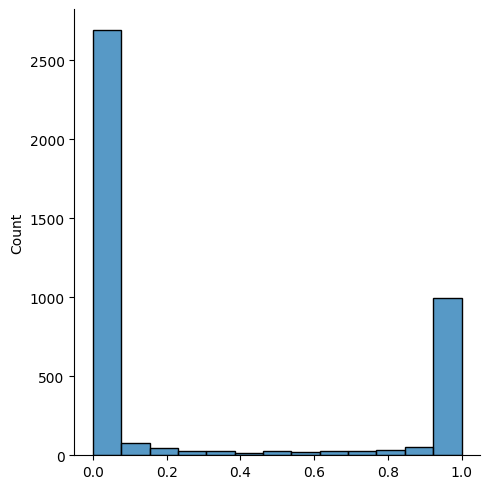

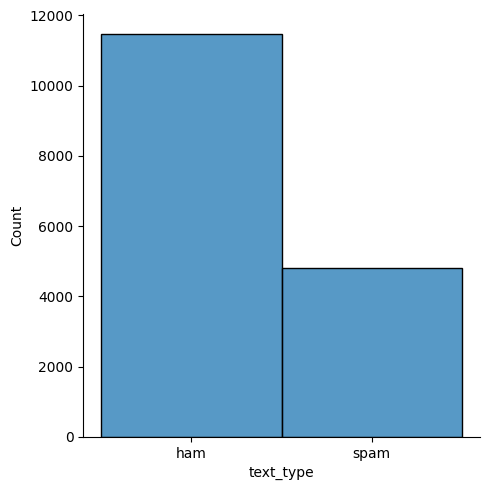

In [ ]:
test_preds = make_oof_prediction(models, test)

submission = pd.DataFrame(data={
    'score': test_preds,
    'text': test['text']
})
submission.to_csv('../submissions/out_of_fold_submission.csv', index=False)

sns.displot(test_preds)
sns.displot(full_train['text_type'])

submission

,score,text
0,0.003153,j jim whitehead ejw cse ucsc edu write j you o...
1,0.005358,origin messag from bitbitch magnesium net peop...
2,0.000245,java for manag vinc durasoft who just taught t...
3,0.010175,there is a youtub name saiman say
4,0.996070,underpr issu with high return on equiti the oi...
...,...,...
4065,0.020293,husband to wifetum meri zindagi hoorwifeor kya...
4066,0.000067,baylor enron case studi cindi yes i shall co a...
4067,0.002811,bore as compar to tp
4068,0.000964,hellogorg how u my fone was on charg lst nitw ...


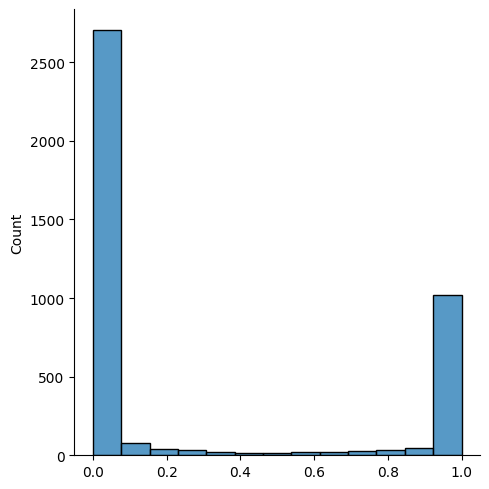

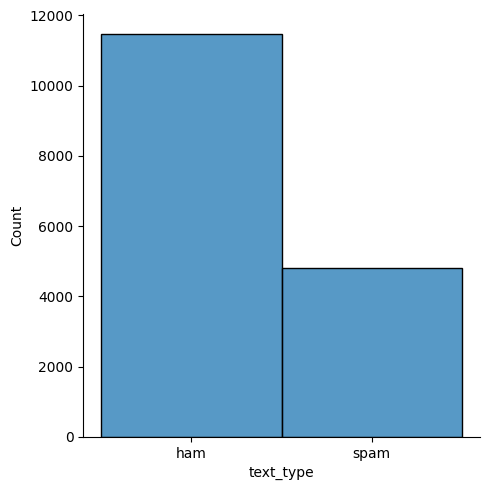

In [ ]:
test_preds = models[np.argmax(metrics)].predict_proba(test)[:, 1]

submission = pd.DataFrame(data={
    'score': test_preds,
    'text': test['text']
})
submission.to_csv('../submissions/best_model_submission.csv', index=False)

sns.displot(test_preds)
sns.displot(full_train['text_type'])

submission